In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
sys.path.append('..')

import pickle
import json
import numpy as np

# Script params

In [3]:
max_len = 150
embedding_dim = 50

# Loading glove embedding

In [4]:
glove_embedding = {}
with open('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/glove.6B.50d.txt', 'r') as f:
    while True:
        line = f.readline()
        if line == '':
            break
        line = line.split()
        glove_embedding[line[0]] = np.asarray(line[1:], dtype='float32')

# Load train and test data

In [5]:
from keras.utils import pad_sequences

2023-08-18 18:28:58.252102: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
with open('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/aclImdb/corpus_train_df.pkl', 'rb') as f:
    train_df = pickle.load(f)
with open('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/aclImdb/corpus_test_df.pkl', 'rb') as f:
    test_df = pickle.load(f)
with open('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/aclImdb/token2index.json', 'r') as f:
    token2index = json.load(f)
with open('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/aclImdb/index2token.json', 'r') as f:
    index2token = json.load(f)

In [7]:
max_index = max(list(token2index.values())) + 1

In [8]:
x_train = pad_sequences(train_df.token_indexes.values, maxlen = max_len)
y_train = train_df.labels.values
x_test = pad_sequences(test_df.token_indexes.values, maxlen = max_len)
y_test = test_df.labels.values

In [9]:
x_train.shape, y_train.shape

((25000, 150), (25000,))

In [10]:
x_test.shape, y_test.shape

((25000, 150), (25000,))

# Create glove based embedding matrix for keras

In [11]:
embedding_matrix = np.zeros((max_index,embedding_dim))

In [12]:
for token, index in token2index.items():
    embedding_vector = glove_embedding.get(token)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Training simple dnn with embedding layer

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Conv1D, MaxPooling1D, LSTM, BatchNormalization
from keras.metrics import AUC, BinaryAccuracy
from keras.optimizers import RMSprop

In [14]:
model = Sequential()
model.add(Embedding(max_index, embedding_dim))
model.add(LSTM(32))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          867100    
                                                                 
 lstm (LSTM)                 (None, 32)                10624     
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 877,997
Trainable params: 877,997
Non-trainable params: 0
_________________________________________________________________


2023-08-18 18:29:08.929339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-18 18:29:08.931096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-18 18:29:08.932812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [15]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [16]:
optimizer = RMSprop(learning_rate=0.0002, momentum = 0.3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[BinaryAccuracy(), AUC()])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          867100    
                                                                 
 lstm (LSTM)                 (None, 32)                10624     
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 877,997
Trainable params: 10,897
Non-trainable params: 867,100
_________________________________________________________________


In [18]:
fit_history = model.fit(x_train,
                        y_train,
                        epochs=30,
                        batch_size=64,
                        validation_data=(x_test, y_test)
                       )

Epoch 1/30


2023-08-18 18:29:09.754788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-18 18:29:09.756350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-18 18:29:09.758262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

390/391 [============================>.] - ETA: 0s - loss: 0.6273 - binary_accuracy: 0.6498 - auc: 0.7058

2023-08-18 18:29:27.178628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-18 18:29:27.180073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-18 18:29:27.181624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

391/391 [==============================] - 22s 53ms/step - loss: 0.6272 - binary_accuracy: 0.6499 - auc: 0.7059 - val_loss: 0.5551 - val_binary_accuracy: 0.7306 - val_auc: 0.8010
Epoch 2/30
391/391 [==============================] - 19s 48ms/step - loss: 0.5427 - binary_accuracy: 0.7418 - auc: 0.8019 - val_loss: 0.5061 - val_binary_accuracy: 0.7606 - val_auc: 0.8386
Epoch 3/30
391/391 [==============================] - 19s 49ms/step - loss: 0.5038 - binary_accuracy: 0.7661 - auc: 0.8338 - val_loss: 0.4759 - val_binary_accuracy: 0.7802 - val_auc: 0.8575
Epoch 4/30
391/391 [==============================] - 19s 48ms/step - loss: 0.4819 - binary_accuracy: 0.7784 - auc: 0.8500 - val_loss: 0.4640 - val_binary_accuracy: 0.7842 - val_auc: 0.8669
Epoch 5/30
391/391 [==============================] - 19s 48ms/step - loss: 0.4638 - binary_accuracy: 0.7920 - auc: 0.8624 - val_loss: 0.4454 - val_binary_accuracy: 0.7975 - val_auc: 0.8767
Epoch 6/30
391/391 [==============================] - 19s 48m

In [19]:
from kst.plots.BasePlots import BasePlots, ScatterPlot
import pandas as pd
from plotnine import aes, geom_point, geom_line, ylim, labs, theme

In [20]:
df = pd.DataFrame.from_dict(fit_history.history)
df['epoch'] = df.index.to_list()
df

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc,epoch
0,0.627242,0.64992,0.705920,0.555079,0.73060,0.801019,0
1,0.542689,0.74180,0.801857,0.506131,0.76064,0.838568,1
2,0.503774,0.76608,0.833840,0.475936,0.78016,0.857471,2
3,0.481948,0.77840,0.849989,0.464011,0.78424,0.866863,3
4,0.463830,0.79196,0.862360,0.445449,0.79752,0.876737,4
5,0.445524,0.80168,0.874081,0.425980,0.80720,0.887227,5
6,0.433032,0.81220,0.881708,0.413782,0.81408,0.893102,6
7,0.423977,0.81360,0.887146,0.419584,0.80848,0.897115,7
8,0.411850,0.82028,0.893948,0.453705,0.78872,0.897343,8
9,0.404584,0.82228,0.897853,0.396744,0.82280,0.903192,9


In [21]:
sc = ScatterPlot(data_set=df,
                 aes = {'x':'epoch', 'y':'loss', 'color':"'training'"},
                 main_title='Binary crossentropy',
                 x_label='Epoch',
                 y_label='Loss',
                 legend_title='',
                 line = geom_line()
              )

sc.add_gg_object(geom_point(df, aes(x = 'epoch', y = 'val_loss', color = "'validation'")))
sc.add_gg_object(geom_line(df, aes(x = 'epoch', y = 'val_loss', color = "'validation'")))

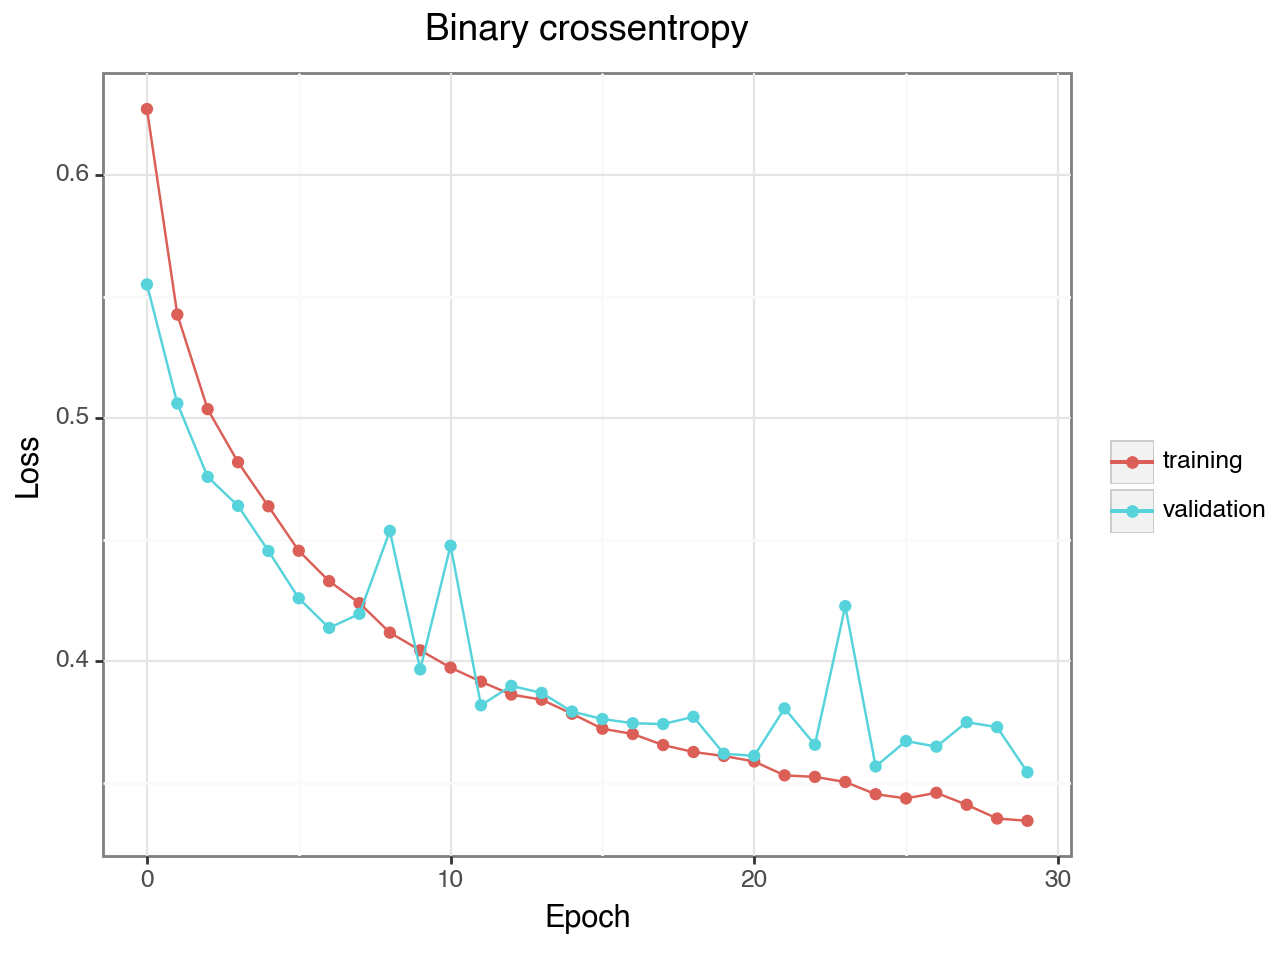

<Figure Size: (640 x 480)>

In [22]:
sc.plot

In [23]:
sc = ScatterPlot(data_set=df,
                 aes = {'x':'epoch', 'y':'auc', 'color':"'training'"},
                 main_title='Area under curve',
                 x_label='Epoch',
                 y_label='Binary accuracy',
                 legend_title='',
                 line = geom_line()
              )

sc.add_gg_object(geom_point(df, aes(x = 'epoch', y = 'val_auc', color = "'validation'")))
sc.add_gg_object(geom_line(df, aes(x = 'epoch', y = 'val_auc', color = "'validation'")))

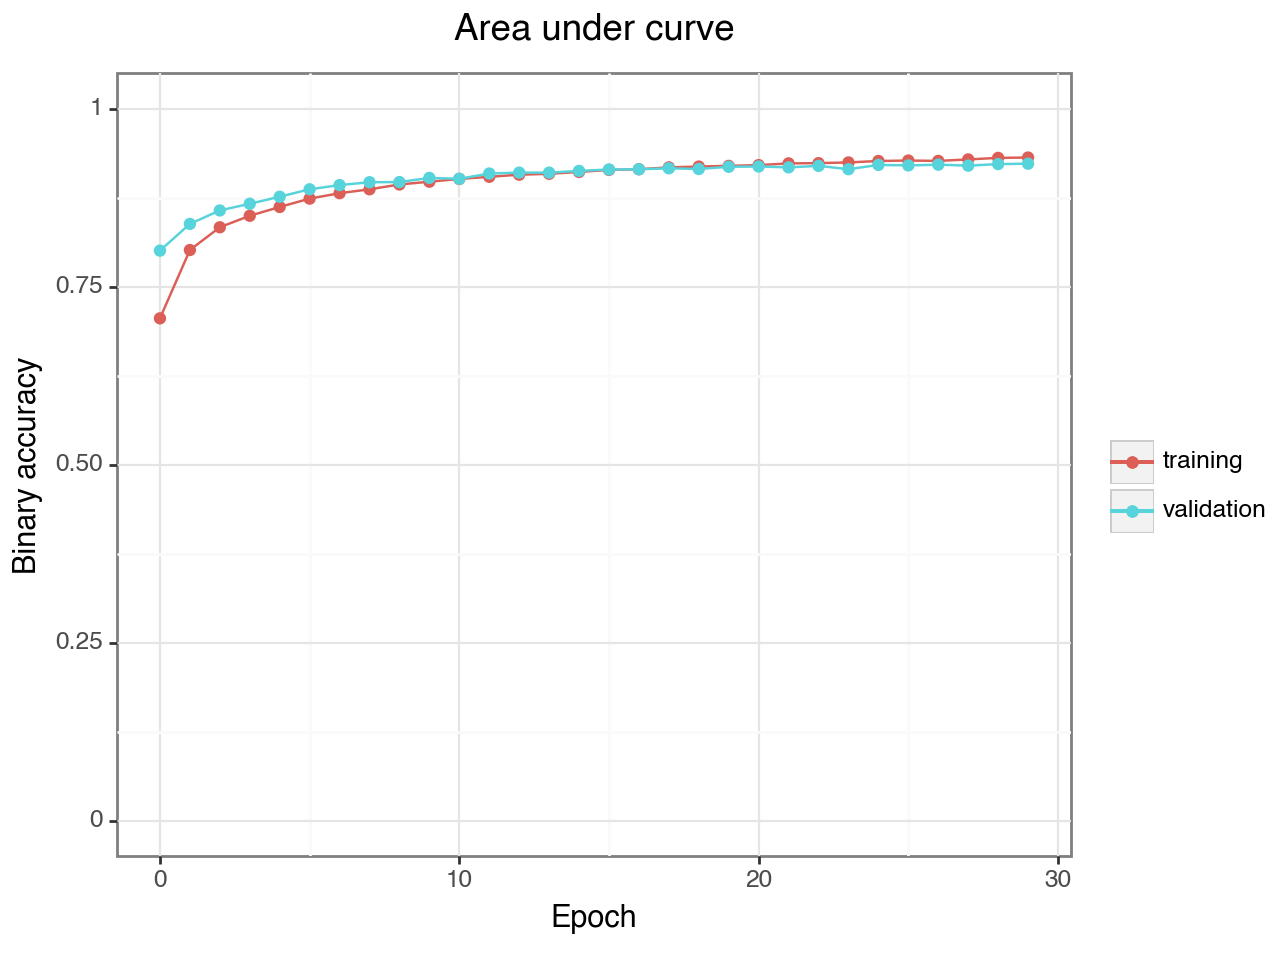

<Figure Size: (640 x 480)>

In [24]:
sc.plot + ylim(0,1)

In [25]:
sc = ScatterPlot(data_set=df,
                 aes = {'x':'epoch', 'y':'binary_accuracy', 'color':"'training'"},
                 main_title='Binarry accuracy',
                 x_label='Epoch',
                 y_label='Binary accuracy',
                 legend_title='',
                 line = geom_line()
              )

sc.add_gg_object(geom_point(df, aes(x = 'epoch', y = 'val_binary_accuracy', color = "'validation'")))
sc.add_gg_object(geom_line(df, aes(x = 'epoch', y = 'val_binary_accuracy', color = "'validation'")))

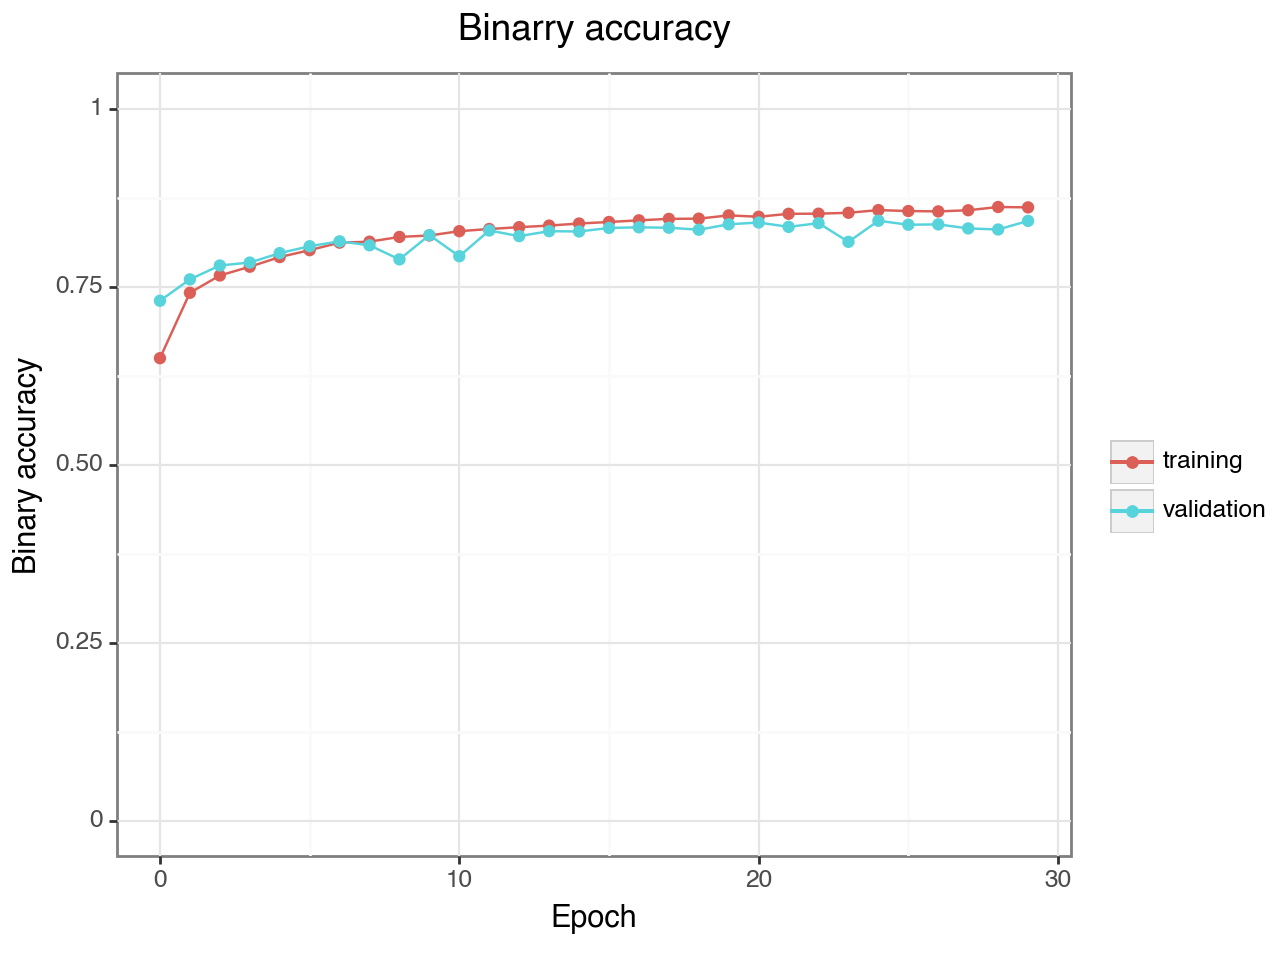

<Figure Size: (640 x 480)>

In [26]:
sc.plot + ylim(0,1)